In [1]:
import psfmodels as psfm
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np
import tifffile
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
import pandas as pd
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from scipy.optimize import minimize, LinearConstraint, Bounds, differential_evolution, basinhopping, shgo, dual_annealing, direct
from skimage.filters import gaussian
from scipy.optimize import LinearConstraint
import numpy as np
from copy import deepcopy
from tqdm.auto import tqdm
def get_midline(arr):
    mid_x = arr.shape[1]//2
    return arr[mid_x]

def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline

def MSLE(arr1, arr2): # MEAN SQUARE LOG ERROR
    return np.nanmean((np.log(arr1 + 1) - np.log(arr2 + 1))**2)

def MSE(arr1, arr2):
    return np.nanmean((arr1 - arr2)**2)

def MLSE(arr1, arr2): # MEAN LOG SQUARE ERROR
    return np.nanmean(np.log((arr1 - arr2)**2 + 1))

def RMLSE(arr1, arr2):
    return np.sqrt(MLSE(arr1,arr2))

def RMSLE(arr1, arr2):
    return np.sqrt(MSLE(arr1, arr2))

loss_fns = [MSLE, MSE, MLSE, RMLSE, RMSLE]

def lorentzian_2d_DoG(amplitude, xo, yo, gamma_x, gamma_y, sigma1, sigma2, offset, amplitude_gauss1, amplitude_gauss2, xdata_tuple):
    (x, y) = xdata_tuple
    lorentz =  amplitude / (1 + ((x - xo) / gamma_x)**2 + ((y - yo) / gamma_y)**2) + offset
    gaussian_term_1 = amplitude_gauss1 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2)) + offset * 10
    gaussian_term_2 = amplitude_gauss2 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    DoG = (gaussian_term_1 - gaussian_term_2)
    DoG = DoG - min(0, DoG.min())
    DoG = DoG
    return lorentz * DoG 

def symmetric_moffat_DoG(amplitude, xo, yo, alpha_x, alpha_y, beta, offset, sigma1, sigma2, amplitude_gauss1, amplitude_gauss2, xdata_tuple):
    (x, y) = xdata_tuple
    moffat_term = amplitude * (1 + ((x - xo)**2 / alpha_x**2) + ((y - yo)**2 / alpha_x**2)) ** (-beta)# + offset
    gaussian_term_1 = amplitude_gauss1 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2)) + offset
    gaussian_term_2 = amplitude_gauss2 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    DoG = (gaussian_term_1 - gaussian_term_2)
    DoG = DoG - min(0, DoG.min())
    
    return moffat_term * DoG

def check_zero_cost(intermediate_result):
    if intermediate_result.fun == 0:
        print(f"Cost is zero for parameters: {intermediate_result.x}")
    return False  # return True if you want to stop the optimization here

def perc_err(act,exp):
    return abs((act - exp)/exp) * 100

def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline

In [2]:
def fit_moffat(real_PSF, error_function, xdata_tuple):
    param_bounds = {
        'amplitude': (0, 5),
        'xo': (0, real_PSF.shape[1]),
        'yo': (0, real_PSF.shape[0]),
        'alpha_x': (0.001, 50),
        'alpha_y': (0.001, 50),
        'beta': (0.01, 20,),
        'offset': (0, 3),
        'sigma1': (1, 50),
        'sigma2': (1, 50),
        'amplitude_gauss1': (0, 10),
        'amplitude_gauss2': (0, 10),
    }
    
    # Create bounds for optimization
    lower_bounds = [param_bounds[name][0] for name in param_bounds]
    upper_bounds = [param_bounds[name][1] for name in param_bounds]
    bounds = Bounds(lower_bounds, upper_bounds)
    
    
    
    # Define the constraint matrix
    A = np.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1],  # amplitude_gauss2 - amplitude_gauss1  > 0
        [0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0]   # sigma2 - sigma1 > 0 (equivalent to sigma1 < sigma2)
    ])
    
    # Define the lower and upper bounds for the inequalities
    lb = [np.finfo(float).eps, np.finfo(float).eps]  # Lower bounds slightly above 0
    ub = [np.inf, np.inf]                            # Upper bounds are infinity
    
    # Create the LinearConstraint object
    constraints = LinearConstraint(A, lb, ub)


    result = differential_evolution(error_function, bounds, workers = 24, disp = False, callback = check_zero_cost, args = (xdata_tuple, real_PSF))
    return result


In [3]:
def get_real_PSF(PSF_size_xyz, z_slice):
    pix_mic_conv = 0.05
    real_PSF = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif").astype(np.float32)
    real_PSF = rescale(real_PSF, (0.05/pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv) , anti_aliasing=True)
    #real_PSF = gaussian(real_PSF, sigma = 0.75)
    midpoint_xy = real_PSF.shape[1]//2
    midpoint_z = real_PSF.shape[0]//2
    
    original_z = real_PSF.shape[0]
    original_xy = real_PSF.shape[1]
    
    max_intensities = real_PSF.max(axis=(1,2))
    peak_intensity_z =  np.argwhere(max_intensities == np.max(max_intensities))[0][0]
    
    
    real_PSF = real_PSF[
        midpoint_z - PSF_size_xyz//2:midpoint_z + PSF_size_xyz//2+1,
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1,
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1
    ]
    
    
    real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
    real_PSF = np.clip(real_PSF, 0, np.inf)
    real_PSF = real_PSF / real_PSF.max()
    real_PSF = real_PSF[z_slice]
    return real_PSF

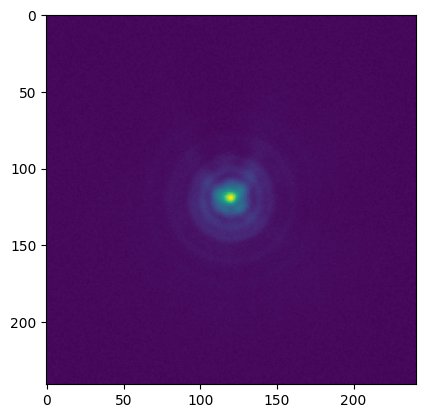

In [4]:
real_PSF = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif").astype(np.float32)
plt.imshow(real_PSF[100])

In [5]:
def fit_lorentz(real_PSF, error_function, xdata_tuple):
    param_bounds = {
        'amplitude': (0, 5),
        'xo': (0, real_PSF.shape[1]),
        'yo': (0, real_PSF.shape[0]),
        'gamma_x': (0.001, 70),
        'gamma_y': (0.001, 70),
        'sigma1': (1, 30),
        'sigma2': (1, 30),
        'offset': (0, 1),
        'amplitude_gauss1': (0, 40),
        'amplitude_gauss2': (0, 40),
    }
    
    # Create bounds for optimization
    lower_bounds = [param_bounds[name][0] for name in param_bounds]
    upper_bounds = [param_bounds[name][1] for name in param_bounds]
    bounds = Bounds(lower_bounds, upper_bounds)
    
    
    
    # Define the constraint matrix
    A = np.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 1, -1],  # amplitude_gauss2 - amplitude_gauss1  > 0
        [0, 0, 0, 0, 0, 1, -1, 0, 0, 0]   # sigma2 - sigma1 > 0 (equivalent to sigma1 < sigma2)
    ])
    
    # Define the lower and upper bounds for the inequalities
    lb = [np.finfo(float).eps, np.finfo(float).eps]  # Lower bounds slightly above 0
    ub = [np.inf, np.inf]                            # Upper bounds are infinity

    # Define the constraint matrix
    A = np.array([
        [0, 0, 0, 0, 0, 1, -1, 0, 0, 0]   # sigma2 - sigma1 > 0 (equivalent to sigma1 < sigma2)
    ])
    
    # Define the lower and upper bounds for the inequalities
    lb = [np.finfo(float).eps]  # Lower bounds slightly above 0
    ub = [np.inf]    
    
    # Create the LinearConstraint object
    constraints = LinearConstraint(A, lb, ub)


    result = differential_evolution(error_function, bounds, workers = 1, disp = False, callback = check_zero_cost, args = (xdata_tuple, real_PSF), updating='immediate')
    return result


In [6]:
def fit_to_PSF(PSF_size_xyz, parameterised_function, fit_function, error_function, z):

    real_PSF = get_real_PSF(PSF_size_xyz, z)
    x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
    y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
    x, y = xdata_tuple = np.meshgrid(x, y)



    result = fit_function(real_PSF, error_function, xdata_tuple)

    #print(result)
    best_fit = parameterised_function(*result.x, (x,y))
    
    MSE_loss = MSLE(best_fit, real_PSF)

    #plt.plot(best_fit[best_fit.shape[0]//2])
    #plt.plot(get_midline_rotate_method(real_PSF), label = "real")

    #plt.yscale("log")
    #plt.title("Fit")
    #plt.show()
    
    return result, MSE_loss, get_midline_rotate_method(best_fit)

def get_extrapolated_fit(result, original_fit_xy, parameterised_function, error_function):
    real_PSF = get_real_PSF(201)
    x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
    y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
    x, y = xdata_tuple = np.meshgrid(x, y)
    best_fit_result = deepcopy(result.x)
    #best_fit_result[1] = best_fit_result[2] = real_PSF.shape[1]/2
    best_fit_result[2] = best_fit_result[2] + real_PSF.shape[1]/2 - original_fit_xy/2
    best_fit_result[1] = best_fit_result[1] + real_PSF.shape[1]/2 - original_fit_xy/2
    best_fit = parameterised_function(*best_fit_result, (x,y))

    #plt.plot(best_fit[best_fit.shape[0]//2])
    #plt.plot(get_midline_rotate_method(real_PSF), label = "real")
    #plt.plot(real_PSF[real_PSF.shape[0]//2], label = "real")

    #plt.yscale("log")
    #plt.title("Extrapolation")
    #plt.show()
    MSE_loss = MSLE(best_fit, real_PSF)
    return error_function(best_fit_result, xdata_tuple, real_PSF), MSE_loss, get_midline_rotate_method(best_fit), get_midline_rotate_method(real_PSF)

In [7]:
from joblib import Parallel, delayed


In [8]:
small_fit_size = 41
real_PSF = get_real_PSF(small_fit_size, 5)
x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = xdata_tuple = np.meshgrid(x, y)

In [9]:
tifffile.imwrite

<function tifffile.tifffile.imwrite(file: 'str | os.PathLike | FileHandle | BinaryIO', /, data: 'ArrayLike | Iterator[numpy.ndarray | None] | Iterator[bytes] | None' = None, *, bigtiff: 'bool | None' = None, byteorder: 'ByteOrder | None' = None, imagej: 'bool' = False, ome: 'bool | None' = None, shaped: 'bool | None' = None, append: 'bool' = False, shape: 'Sequence[int] | None' = None, dtype: 'numpy.dtype | str | None' = None, photometric: 'PHOTOMETRIC | int | str | None' = None, planarconfig: 'PLANARCONFIG | int | str | None' = None, extrasamples: 'Sequence[EXTRASAMPLE | int | str] | None' = None, volumetric: 'bool' = False, tile: 'Sequence[int] | None' = None, rowsperstrip: 'int | None' = None, bitspersample: 'int | None' = None, compression: 'COMPRESSION | int | str | None' = None, compressionargs: 'dict[str, Any] | None' = None, predictor: 'PREDICTOR | int | str | bool | None' = None, subsampling: 'tuple[int, int] | None' = None, jpegtables: 'bytes | None' = None, colormap: 'ArrayL

In [ ]:
fits = []
a = 0
for _ in range(20):
    for loss_fn in loss_fns:
        def error_function(params, *args):
            synthetic = lorentzian_2d_DoG(*params, args[0])
            return loss_fn(synthetic, args[1])
    
        def fit_z(z):    
        
            
            #print(loss_fn)
            
            result, MSE_loss_50px, fit_midline = fit_to_PSF(small_fit_size, lorentzian_2d_DoG, fit_lorentz, error_function, z)
            #results.append(result)
        
        
            #fit_x = np.arange(-len(fit_midline)/2, len(fit_midline)/2)
        
            return result.x
        
        results = Parallel(n_jobs=-1)(delayed(fit_z)(z) for z in tqdm(range(41)))
        fit = np.array([lorentzian_2d_DoG(*results[z], xdata_tuple) for z in range(41)])
        tifffile.imwrite(f"lorentz_xyz_fits/{a}.tif", fit)
        fits.append(fit)
        a+=1
        print(loss_fn)
        #plt.imshow(fit.sum(axis=2), cmap="Greys_r")
        #plt.show()

  0%|          | 0/41 [00:00<?, ?it/s]

<function MSLE at 0x7a716ae44550>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSE at 0x7a716ae445e0>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MLSE at 0x7a716ae44670>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMLSE at 0x7a716ae44700>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMSLE at 0x7a716ae44790>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSLE at 0x7a716ae44550>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSE at 0x7a716ae445e0>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MLSE at 0x7a716ae44670>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMLSE at 0x7a716ae44700>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMSLE at 0x7a716ae44790>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSLE at 0x7a716ae44550>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSE at 0x7a716ae445e0>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MLSE at 0x7a716ae44670>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMLSE at 0x7a716ae44700>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMSLE at 0x7a716ae44790>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSLE at 0x7a716ae44550>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSE at 0x7a716ae445e0>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MLSE at 0x7a716ae44670>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMLSE at 0x7a716ae44700>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMSLE at 0x7a716ae44790>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSLE at 0x7a716ae44550>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSE at 0x7a716ae445e0>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MLSE at 0x7a716ae44670>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMLSE at 0x7a716ae44700>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMSLE at 0x7a716ae44790>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSLE at 0x7a716ae44550>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSE at 0x7a716ae445e0>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MLSE at 0x7a716ae44670>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMLSE at 0x7a716ae44700>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMSLE at 0x7a716ae44790>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSLE at 0x7a716ae44550>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSE at 0x7a716ae445e0>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MLSE at 0x7a716ae44670>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMLSE at 0x7a716ae44700>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMSLE at 0x7a716ae44790>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSLE at 0x7a716ae44550>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSE at 0x7a716ae445e0>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MLSE at 0x7a716ae44670>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMLSE at 0x7a716ae44700>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMSLE at 0x7a716ae44790>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSLE at 0x7a716ae44550>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSE at 0x7a716ae445e0>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MLSE at 0x7a716ae44670>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMLSE at 0x7a716ae44700>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMSLE at 0x7a716ae44790>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSLE at 0x7a716ae44550>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MSE at 0x7a716ae445e0>


  0%|          | 0/41 [00:00<?, ?it/s]

<function MLSE at 0x7a716ae44670>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMLSE at 0x7a716ae44700>


  0%|          | 0/41 [00:00<?, ?it/s]

<function RMSLE at 0x7a716ae44790>


  0%|          | 0/41 [00:00<?, ?it/s]

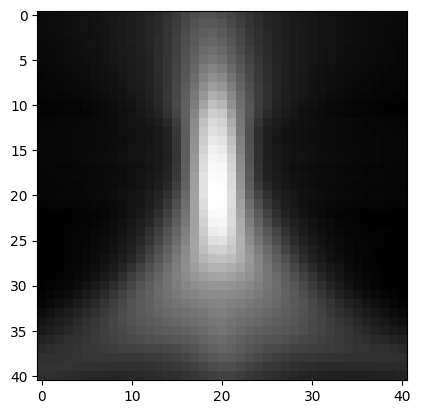

In [11]:
plt.imshow(np.array(fits).sum(axis=0).sum(axis=2), cmap = "Greys_r")

In [14]:
tifffile.imwrite("ePSF_fitted_50nm_pix_xyz.tif", np.array(fits))